# Lecture 10:  Sparse direct solvers

## Recap of the previous part

- Distributed memory for huge dense matrices
- Sparse matrix formats (COO, CSR, CSC)
- Matrix-by-vector product
- Inefficiency of sparse matrix processing
- Approaches to reduce cache misses
- Fill-in of the sparse matrix

## Plan for the next part

Sparse direct solvers: 

- nested dissection
- spectral clustering in details

## Fill-in: reminder

- The fill-in of a matrix are those entries which **change from an initial zero to a nonzero** value during the execution of an algorithm.

## Gaussian elimination for sparse matrices

Given matrix $A=A^*>0$ we calculate its Cholesky decomposition $A = LL^*$.

Factor $L$ can be dense even if $A$ is sparse:

$$
\begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix} = 
\begin{bmatrix} * &  &  &  \\ * & * &  &  \\ * & * & * &  \\ * & * & * & * \end{bmatrix}
\begin{bmatrix} * & * & * & * \\  & * & * & * \\  &  & * & * \\  &  &  & * \end{bmatrix}
$$

How to make factors sparse, i.e. to minimize the **fill-in**?

## Gaussian elimination and permutation

We need to find a permutation of indices so that factors are sparse, i.e. we build Cholesky factorisation of $PAP^\top$, where $P$ is a permutation matrix.

For the example from the previous slide

$$
P \begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix} P^\top = 
\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\ * & * & * & * \end{bmatrix} = 
\begin{bmatrix} * &  &  &  \\  & * &  &  \\  &  & * &  \\ * & * & * & * \end{bmatrix}
\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\  & &  & * \end{bmatrix}
$$

where

$$
P = \begin{bmatrix}  &  &  & 1 \\  &  & 1 &  \\  & 1 &  &  \\ 1 &  &  &  \end{bmatrix}
$$

- Arrowhead form of the matrix gives sparse factors in LU decomposition

Original matrix


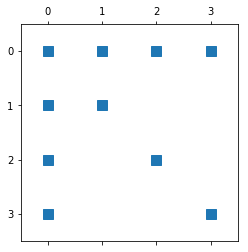

L factor


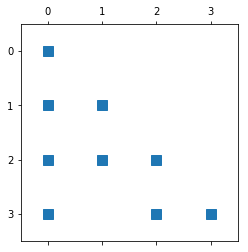

U factor


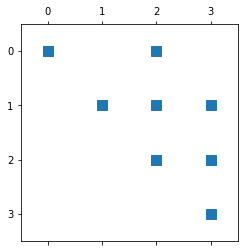

Column permutation: [0 1 2 3]
Row permutation: [1 2 0 3]


In [45]:
import numpy as np
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import scipy.linalg as splin
import matplotlib.pyplot as plt
%matplotlib inline

A = spsp.coo_matrix((np.random.randn(10), ([0, 0, 0, 0, 1, 1, 2, 2, 3, 3], 
                                           [0, 1, 2, 3, 0, 1, 0, 2, 0, 3])))
print("Original matrix")
plt.spy(A)
plt.show()
lu = spsplin.splu(A.tocsc(), permc_spec="NATURAL")
print("L factor")
plt.spy(lu.L)
plt.show()
print("U factor")
plt.spy(lu.U)
plt.show()
print("Column permutation:", lu.perm_c)
print("Row permutation:", lu.perm_r)

### Block arrowhead structure

$$
PAP^\top = \begin{bmatrix} A_{11} &  & A_{13} \\  & A_{22} & A_{23} \\ A_{31} & A_{32} & A_{33}\end{bmatrix}
$$

then

$$
PAP^\top = \begin{bmatrix} A_{11} & 0 & 0 \\ 0 & A_{22} & 0 \\ A_{31} & A_{32} & A_{33} - A_{31}A_{11}^{-1} A_{13} - A_{32}A_{22}^{-1}A_{23} \end{bmatrix} \begin{bmatrix}  I & 0 & A_{11}^{-1}A_{13} \\ 0 & I & A_{22}^{-1}A_{23} \\ 0 & 0 & I\end{bmatrix}
$$

- Block $ A_{33} - A_{31}A_{11}^{-1} A_{13} - A_{32}A_{22}^{-1}A_{23}$ is Schur complement for block diagonal matrix $\begin{bmatrix} A_{11} & 0 \\ 0 & A_{22} \end{bmatrix}$
- We reduce problem to solving smaller linear systems with $A_{11}$ and $A_{22}$ 

### How can we find permutation?

- Key idea comes from graph theory
- Sparse matrix can be treated as an **adjacency matrix** of a certain graph:
the vertices $(i, j)$ are connected, if the corresponding matrix element is non-zero.


### Example

Graphs of $\begin{bmatrix} * & * & * & * \\ * & * &  &  \\ * &  & * &  \\ * &  &  & * \end{bmatrix}$ and $\begin{bmatrix} * &  &  & *  \\  & * &  & * \\  &  & * & * \\ * & * & * & * \end{bmatrix}$ have the following form:

<img src="graph_dense.png" width=300 align="center"> and <img src="graph_sparse.png" width=300 align="center">

* Why the second ordering is better than the first one?

### Graph separator

**Definition.** A **separator** in a graph $G$ is a set $S$ of vertices whose removal leaves at
least two connected components.

Separator $S$ gives the following ordering for an $N$-vertex graph $G$:
- Find a separator $S$, whose removal leaves connected components
$T_1$, $T_2$, $\ldots$, $T_k$
- Number the vertices of $S$ from $N − |S| + 1$ to $N$
- Recursively, number the vertices of each component: $T_1$ from $1$ to
$|T_1|$, $T_2$ from $|T_1| + 1$ to $|T_1| + |T_2|$, etc
- If a component is small enough, enumeration in this component is arbitrarily

### Separator and block arrowhead structure: example

Separator for the 2D Laplacian matrix 

$$
 A_{2D} = I \otimes A_{1D} + A_{1D} \otimes I, \quad A_{1D} = \mathrm{tridiag}(-1, 2, -1),
$$

is as follows

<img src='separator.png' width=300> </img>

Once we have enumerated first indices in $\alpha$, then in $\beta$ and separators indices in $\sigma$ we get the following matrix

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} &  & A_{\alpha\sigma} \\  & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix}
$$

which has arrowhrad structure.

- Thus, the problem of finding **permutation** was reduced to the problem of finding **graph separator**!

### Nested dissection

- For blocks $A_{\alpha\alpha}$, $A_{\beta\beta}$ we continue splitting recursively.

- When the recursion is done, we need to eliminate blocks $A_{\sigma\alpha}$ and $A_{\sigma\beta}$. 

- This makes block in the position of $A_{\sigma\sigma}\in\mathbb{R}^{n\times n}$ dense.

Calculation of Cholesky of this block costs $\mathcal{O}(n^3) = \mathcal{O}(N^{3/2})$, where $N = n^2$ is the total number of nodes.

So, the complexity is $\mathcal{O}(N^{3/2})$

## Packages for nested dissection

- MUltifrontal Massively Parallel sparse direct Solver ([MUMPS](http://mumps.enseeiht.fr/))
- [Pardiso](https://www.pardiso-project.org/)
- [Umfpack as part of SuiteSparse](http://faculty.cse.tamu.edu/davis/suitesparse.html)

All of them have interfaces for C/C++, Fortran and Matlab 

### Nested dissection summary

- Enumeration: find a separator.
- Divide-and-conquer paradigm
- Recursively process two subsets of vertices after separation
- In theory, nested dissection gives optimal complexity. 
- In practice, it beats others only for very large problems.

## Separators in practice

- Computing separators is not a **trivial task**.

- Graph partitioning heuristics has been an active research area for many years, often motivated by partitioning for parallel computation.

Existing approaches:

- Spectral partitioning (uses eigenvectors of Laplacian matrix of graph) - more details below
- Geometric partitioning (for meshes with specified vertex coordinates) [review and analysis](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.31.4886&rep=rep1&type=pdf)
- Iterative-swapping ([(Kernighan-Lin, 1970)](http://xilinx.asia/_hdl/4/eda.ee.ucla.edu/EE201A-04Spring/kl.pdf), [(Fiduccia-Matheysses, 19820](https://dl.acm.org/citation.cfm?id=809204))
- Breadth-first search [(Lipton, Tarjan 1979)](http://www.cs.princeton.edu/courses/archive/fall06/cos528/handouts/sepplanar.pdf)
- Multilevel recursive bisection (heuristic, currently most practical) ([review](https://people.csail.mit.edu/jshun/6886-s18/lectures/lecture13-1.pdf) and [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.499.4130&rep=rep1&type=pdf)). Package for such kind of partitioning is called METIS, written in C, and available [here](http://glaros.dtc.umn.edu/gkhome/views/metis)

## Spectral graph partitioning

The idea of spectral partitioning goes back to Miroslav Fiedler, who studied connectivity of graphs ([paper](https://dml.cz/bitstream/handle/10338.dmlcz/101168/CzechMathJ_23-1973-2_11.pdf)).

We need to split the vertices into two sets.

Consider +1/-1 labeling of vertices and **the cost**

$$E_c(x) = \sum_{j} \sum_{i \in N(j)} (x_i - x_j)^2, \quad N(j) \text{ denotes set of neighbours of a node } j. $$

We need a balanced partition, thus 

$$\sum_i x_i =  0 \quad \Longleftrightarrow \quad x^\top e = 0, \quad e = \begin{bmatrix}1 & \dots & 1\end{bmatrix}^\top,$$

and since we have +1/-1 labels, we have

$$\sum_i x^2_i = n \quad \Longleftrightarrow \quad \|x\|_2^2 = n.$$

## Graph Laplacian

Cost $E_c$ can be written as (check why)

$$E_c = (Lx, x)$$

where $L$ is the **graph Laplacian**, which is defined as a symmetric matrix with

$$L_{ii} = \mbox{degree of node $i$},$$

$$L_{ij} = -1, \quad \mbox{if $i \ne j$  and there is an edge},$$

and $0$ otherwise.

- Rows of $L$ sum to zero, thus there is an eigenvalue $0$ and gives trivial eigenvector of all ones.
- Eigenvalues are non-negative (why?).

## Partitioning as an optimization problem

Minimization of $E_c$ with the mentioned constraints leads to a partitioning that tries to minimize number of edges in a separator, while keeping the partition balanced. 

We now relax the integer quadratic programming to the continuous quadratic programming

$$E_c(x) = (Lx, x)\to \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}}$$

## Fiedler vector
- The solution to the minimization problem is given by the eigenvector (called Fiedler vector) corresponding  to the second smallest eigenvalue of the graph Laplacian. Indeed,

$$
    \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}} (Lx, x) = n \cdot \min_{{x^\top e =0}} \frac{(Lx, x)}{(x, x)} = n \cdot \min_{{x^\top e =0}} R(x), \quad R(x) \text{ is the Rayleigh quotient}
$$

- Since $e$ is the eigenvector, corresponding to the smallest eigenvalue, on the space $x^\top e =0$ we get the second minimal eigevalue.

- The sign $x_i$ indicates the partitioning.

- In computations, we need to find out, how to find this second minimal eigenvalue –– we at least know about power method, but it finds the largest. We will discuss iterative methods for eigenvalue problems later in our course.

- This is the main goal of the iterative methods for large-scale linear problems, and can be achieved via few matrix-by-vector products.

Number of vertices = 34
Number of edges = 78


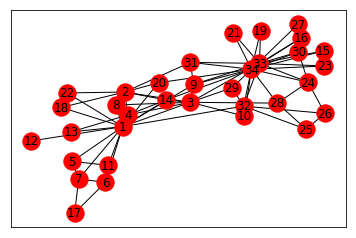

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
kn = nx.read_gml('karate.gml')
print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))
nx.draw_networkx(kn, node_color="red") #Draw the graph

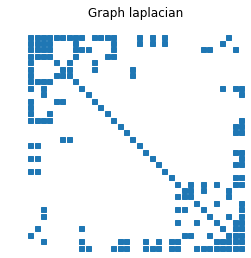

The 2 smallest eigenvalues = [-4.14058418e-15  4.68525227e-01]


In [4]:
import scipy.sparse.linalg as spsplin
Laplacian = nx.laplacian_matrix(kn).asfptype()
plt.spy(Laplacian, markersize=5)
plt.title("Graph laplacian")
plt.axis("off")
plt.show()
eigval, eigvec = spsplin.eigsh(Laplacian, k=2, which="SM")
print("The 2 smallest eigenvalues =", eigval)

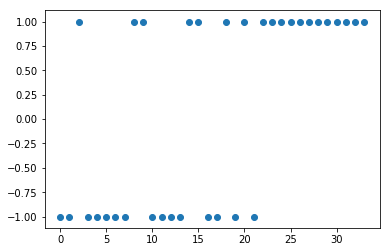

Sum of elements in Fiedler vector = 8.743006318923108e-16


In [5]:
plt.scatter(np.arange(len(eigvec[:, 1])), np.sign(eigvec[:, 1]))
plt.show()
print("Sum of elements in Fiedler vector = {}".format(np.sum(eigvec[:, 1].real)))

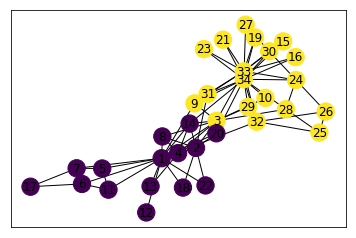

In [6]:
nx.draw_networkx(kn, node_color=np.sign(eigvec[:, 1]))

### Summary on demo

- Here we call SciPy sparse function to find fixed number of eigenvalues (and eigenvectors) that are smallest (other options are possible)
- Details of the underlying method we will discuss soon
- Fiedler vector gives simple separation of the graph
- To separate graph on more than two parts you should use eigenvectors of laplacian as feature vectors and run some clustering algorithm, e.g. $k$-means

### Fiedler vector and algebraic connectivity of a graph

**Definition.** The algebraic connectivity of a graph is the second-smallest eigenvalue of the Laplacian matrix.

**Claim.** The algebraic connectivity of a graph is greater than 0 if and only if a graph is a connected graph.

## Minimal degree orderings

- The idea is to eliminate rows and/or columns with fewer non-zeros, update fill-in and then repeat

- Efficient implementation is an issue (adding/removing elements).

- Current champion is "approximate minimal degree" by Amestoy, Davis, Duff.

- It is **suboptimal** even for 2D problems

- In practice, it often wins for medium-sized problems

- SciPy sparse package [uses](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.splu.html) minimal ordering approach for different matrices ($A^{\top}A$, $A + A^{\top}$) 

## Take home message

- Separators and how do they help in fill-in minimization
- Nested dissection idea
- Fiedler vector and spectral bipartitioning
- Other orderings from SciPy sparse package

## Plan for the next part

- Basic iterative methods for solving large linear systems
- Convergence 
- Acceleration

# Questions?

In [16]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()